In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(2)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetClean/train
# !mkdir ../datasetClean/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=224,size=224):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_volumen,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetAltura2/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=8)

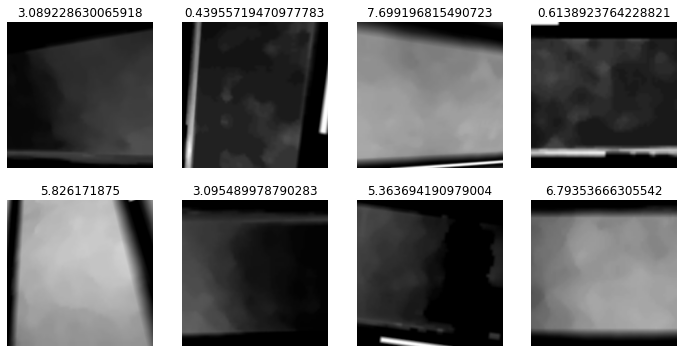

In [15]:
dls.show_batch()

In [16]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='efficientnetv2_rw_s_volumen_height')
]

In [17]:
from fastai.metrics import mae,rmse,mse

In [18]:
learn = Learner(dls, timm.create_model('efficientnetv2_rw_s',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,30.895765,51.213837,5.586504,7.156384,51.213837,00:08


Better model found at epoch 0 with valid_loss value: 51.213836669921875.


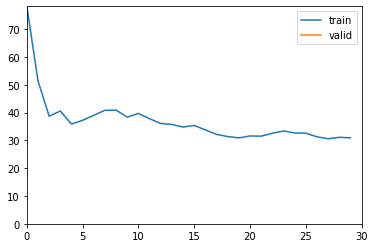

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,22.897945,9.348058,2.492164,3.057460,9.348058,00:07
1,12.734167,3.782117,1.717991,1.944767,3.782117,00:08
2,8.482543,2.373957,1.343343,1.540765,2.373957,00:08
3,5.935496,1.508130,1.055597,1.228060,1.508130,00:08
4,4.591946,1.200386,0.962040,1.095621,1.200386,00:08
5,3.582302,1.082371,0.848714,1.040370,1.082371,00:08
6,3.115220,0.955435,0.833870,0.977463,0.955435,00:08
7,2.524091,0.767852,0.723906,0.876272,0.767852,00:08
8,2.289095,0.609270,0.638726,0.780557,0.609270,00:08
9,2.086145,0.962741,0.876513,0.981194,0.962741,00:08


Better model found at epoch 0 with valid_loss value: 9.348057746887207.


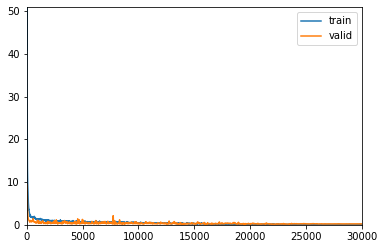

Better model found at epoch 1 with valid_loss value: 3.7821171283721924.
Better model found at epoch 2 with valid_loss value: 2.3739571571350098.
Better model found at epoch 3 with valid_loss value: 1.508130431175232.
Better model found at epoch 4 with valid_loss value: 1.2003862857818604.
Better model found at epoch 5 with valid_loss value: 1.082370638847351.
Better model found at epoch 6 with valid_loss value: 0.9554345011711121.
Better model found at epoch 7 with valid_loss value: 0.7678519487380981.
Better model found at epoch 8 with valid_loss value: 0.6092697978019714.
Better model found at epoch 21 with valid_loss value: 0.5842960476875305.
Better model found at epoch 25 with valid_loss value: 0.48863479495048523.
Better model found at epoch 26 with valid_loss value: 0.39016193151474.
Better model found at epoch 34 with valid_loss value: 0.3236583173274994.
Better model found at epoch 42 with valid_loss value: 0.3177230954170227.
Better model found at epoch 50 with valid_loss va

In [20]:
learn.fine_tune(1000,base_lr=1e-3)

In [21]:
# learn.load('efficientnetv2_rw_s_masa_height')

In [22]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [23]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_volumen,
                 item_tfms = Resize(224),
                 batch_tfms=[*aug_transforms(size=224,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [24]:
dlstest = dbtest.dataloaders(path,bs=8)

In [25]:
learn.dls=dlstest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.29742610454559326.


(#4) [0.161600261926651,0.29742610454559326,0.40199536085128784,0.161600261926651]

In [27]:
from sklearn.metrics import mean_absolute_error

In [28]:
preds,gt = learn.tta()

In [29]:
mean_absolute_error(gt,preds)

0.27613354